# Permanent Algorithm Performance Assessment

This notebook is dedicated to assessing the performance of the different permanent computing algorithms:
- **Ryser**: Standard algorithm iterating over all column subsets
- **Ryser (Gray code)**: Optimized with Gray code for faster subset transitions
- **Ryser Hyperrect**: Specialized for repeated sub-matrices
- **Ryser Hyperrect (Gray code)**: Combined optimizations for repeated sub-matrices

We will benchmark these algorithms and analyze their performance characteristics.

In [2]:
import sys
import os
from math import comb
from math import ceil
from itertools import product
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import signal

# Clear any previous state
if 'results_standard' in dir():
    del results_standard
if 'results_hyperrect' in dir():
    del results_hyperrect
if 'results_all' in dir():
    del results_all

# Add parent directory to path for imports
sys.path.insert(0, os.path.abspath('..'))
from rnd_module import random_unitary, random_fock_uniform, random_fock_sparse
from permanent import ryser, ryser_gray, ryser_hyperrect, ryser_hyperrect_gray, repeat_matrix

# Set random seed for reproducibility
np.random.seed(42)

# os.environ["OMP_NUM_THREADS"] = "1"
# os.environ["MKL_NUM_THREADS"] = "1"
# os.environ["OPENBLAS_NUM_THREADS"] = "1"

class TimeoutException(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutException("Function execution timed out!")


## Section 1: Standard Ryser Algorithms Performance

Benchmarking the basic Ryser algorithm vs the Gray code optimized version on complete random unitary matrices.

In [3]:
def benchmark_standard_ryser(max_size=10, step=2, num_trials=3, timeout_seconds=30):
    """Benchmark standard Ryser algorithms with timeout protection.
    
    Parameters
    ----------
    max_size : int
        Maximum size of the square matrix to test.
    step : int
        Step size for increasing matrix dimensions.
    num_trials : int
        Number of trials to average for each matrix size.
    timeout_seconds : int
        Maximum time (in seconds) to allow for each ryser() call.
    """
    sizes = list(range(step, max_size + 1, step))
    results = {'sizes': sizes, 'ryser': [], 'ryser_gray': []}
    
    for n in sizes:
        times_ryser = []
        times_ryser_gray = []
        print(f"Testing matrix size {n}×{n}...")
        
        for trial in range(num_trials):
            U = random_unitary(n)
            
            # Benchmark ryser with timeout
            try:
                signal.signal(signal.SIGALRM, timeout_handler)
                signal.alarm(timeout_seconds)  # Active le timeout
                
                start = time.time()
                _ = ryser(U)
                t_ryser = time.time() - start
                times_ryser.append(t_ryser)
                
                signal.alarm(0)
            except TimeoutException:
                print(f"  ⚠️  Ryser TIMEOUT (>{timeout_seconds}s) at n={n}, trial {trial+1}")
                times_ryser.append(None)
            
            # Benchmark ryser_gray with timeout
            try:
                signal.signal(signal.SIGALRM, timeout_handler)
                signal.alarm(timeout_seconds)
                
                start = time.time()
                _ = ryser_gray(U)
                t_ryser_gray = time.time() - start
                times_ryser_gray.append(t_ryser_gray)
                
                signal.alarm(0)
            except TimeoutException:
                print(f"  ⚠️  Ryser Gray TIMEOUT (>{timeout_seconds}s) at n={n}, trial {trial+1}")
                times_ryser_gray.append(None)
            
            # Print results
            t1_str = f"{times_ryser[-1]:.4f}s" if times_ryser[-1] else "TIMEOUT"
            t2_str = f"{times_ryser_gray[-1]:.4f}s" if times_ryser_gray[-1] else "TIMEOUT"
            print(f"  Trial {trial + 1}/{num_trials}: Ryser: {t1_str}, Ryser Gray: {t2_str}")
        
        # Compute averages
        valid_ryser = [t for t in times_ryser if t is not None]
        valid_ryser_gray = [t for t in times_ryser_gray if t is not None]
        
        if valid_ryser:
            results['ryser'].append(np.mean(valid_ryser))
        else:
            results['ryser'].append(None)
        
        if valid_ryser_gray:
            results['ryser_gray'].append(np.mean(valid_ryser_gray))
        else:
            results['ryser_gray'].append(None)
    
    return results

# Run with 30s timeout
print("="*80)
print("STANDARD RYSER ALGORITHMS BENCHMARK (with 30s timeout)")
print("="*80)
results_standard = benchmark_standard_ryser(max_size=25, step=5, num_trials=3, timeout_seconds=30)
print("\nBenchmark completed!")

STANDARD RYSER ALGORITHMS BENCHMARK (with 30s timeout)
Testing matrix size 5×5...
  Trial 1/3: Ryser: 0.0002s, Ryser Gray: 0.0009s
  Trial 2/3: Ryser: 0.0003s, Ryser Gray: 0.0001s
  Trial 3/3: Ryser: 0.0002s, Ryser Gray: 0.0001s
Testing matrix size 10×10...
  Trial 1/3: Ryser: 0.0123s, Ryser Gray: 0.0026s
  Trial 2/3: Ryser: 0.0062s, Ryser Gray: 0.0018s
  Trial 3/3: Ryser: 0.0038s, Ryser Gray: 0.0018s
Testing matrix size 15×15...
  Trial 1/3: Ryser: 0.1517s, Ryser Gray: 0.0511s
  Trial 2/3: Ryser: 0.1499s, Ryser Gray: 0.0468s
  Trial 3/3: Ryser: 0.1623s, Ryser Gray: 0.0490s
Testing matrix size 20×20...
  Trial 1/3: Ryser: 6.5219s, Ryser Gray: 1.5554s
  Trial 2/3: Ryser: 5.8065s, Ryser Gray: 1.5390s
  Trial 3/3: Ryser: 5.8508s, Ryser Gray: 1.5405s
Testing matrix size 25×25...
  ⚠️  Ryser TIMEOUT (>30s) at n=25, trial 1
  ⚠️  Ryser Gray TIMEOUT (>30s) at n=25, trial 1
  Trial 1/3: Ryser: TIMEOUT, Ryser Gray: TIMEOUT
  ⚠️  Ryser TIMEOUT (>30s) at n=25, trial 2
  ⚠️  Ryser Gray TIMEOUT (>3

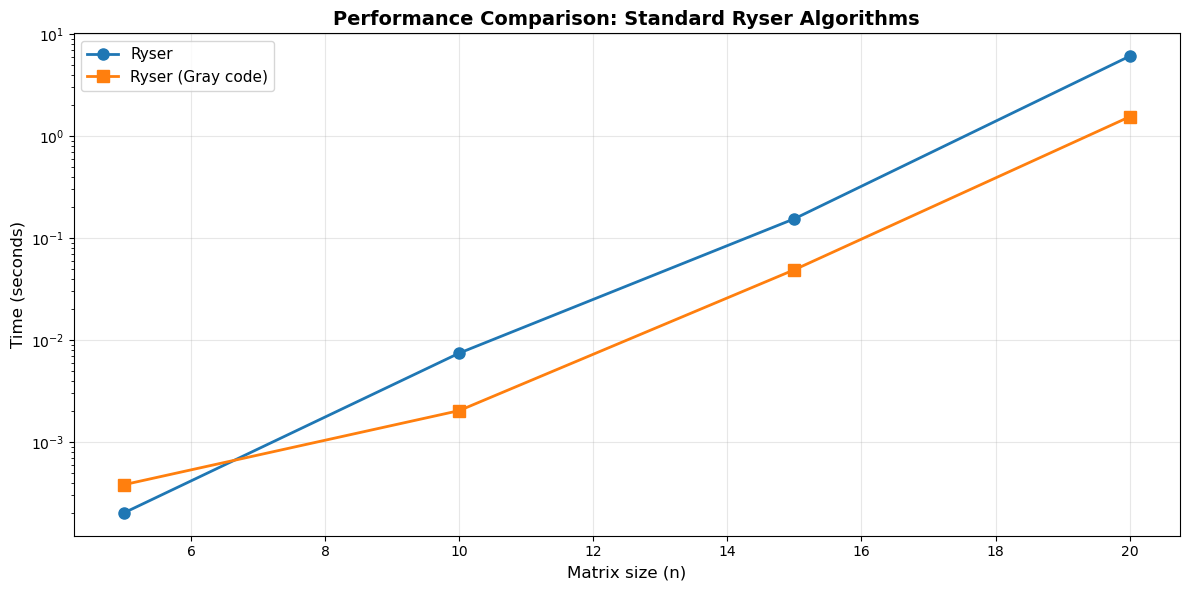


Speedup (Ryser vs Gray code):
  n=5: 0.53x faster
  n=10: 3.66x faster
  n=15: 3.16x faster
  n=20: 3.92x faster
  n=25: N/A due to timeout


In [4]:
# Plot comparison of standard Ryser algorithms
plt.figure(figsize=(12, 6))

sizes = results_standard['sizes']
plt.plot(sizes, results_standard['ryser'], 'o-', label='Ryser', linewidth=2, markersize=8, color='#1f77b4')
plt.plot(sizes, results_standard['ryser_gray'], 's-', label='Ryser (Gray code)', linewidth=2, markersize=8, color='#ff7f0e')

plt.xlabel('Matrix size (n)', fontsize=12)
plt.ylabel('Time (seconds)', fontsize=12)
plt.title('Performance Comparison: Standard Ryser Algorithms', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='upper left')
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()

# Compute speedup

speedup_standard = [results_standard['ryser'][i] / results_standard['ryser_gray'][i] if (results_standard['ryser'][i] is not None and results_standard['ryser_gray'][i] is not None) else None for i in range (len(sizes))]
print(f"\nSpeedup (Ryser vs Gray code):")
for n, s in zip(sizes, speedup_standard):
    print(f"  n={n}: {s:.2f}x faster" if s is not None else f"  n={n}: N/A due to timeout")

## Section 2: Hyperrectangular Ryser Algorithms Performance

Benchmarking specialized algorithms for repeated sub-matrices with varying photon counts.

In [5]:
def benchmark_hyperrect_ryser(
    max_photons=8, step=2, num_trials=3, photon_mode_ratio=10, sparsity='uniform', timeout_seconds=30):
    """Benchmark hyperrectangular Ryser algorithms on repeated sub-matrices.
    
    Parameters
    ----------
    max_photons : int
        Maximum number of total photons to test.
    step : int
        Step size for increasing the number of photons.
    num_trials : int
        Number of trials for each configuration.
    photon_mode_ratio : int or string
        Ratio of the number of modes N compared to the number of photons n. If 'square', N = n^2.
    sparsity : float or str
        Sparsity level for photon distribution (number of non-zero occupations expressed as a
        fraction of the number of photons). If 'uniform', uses uniform distribution.
    timeout_seconds : int
        Maximum time (in seconds) to allow for each ryser_hyperrect() and ryser_hyperrect_gray() call.
    
    Returns
    -------
    dict
        Dictionary containing timing results for each algorithm.
    """
    if isinstance(photon_mode_ratio, str) and (photon_mode_ratio != 'square'):
        raise ValueError("Invalid value for photon_mode_ratio. Use a positive integer or 'square'.")
    if isinstance(photon_mode_ratio, int) and (photon_mode_ratio <= 0):
        raise ValueError("photon_mode_ratio must be a positive integer or 'square'.")
    if isinstance(sparsity, str) and (sparsity != 'uniform'):
        raise ValueError("Invalid value for sparsity. Use a positive float or 'uniform'.")
    if isinstance(sparsity, float) and (sparsity <= 0):
        raise ValueError("sparsity must be positive or 'uniform'.")
    
    results = {
        'photons': [],
        'ryser_hyperrect': [],
        'ryser_hyperrect_gray': []
    }
    
    for n_photons in range(step, max_photons + 1, step):
        times_hyperrect = []
        times_hyperrect_gray = []
        N = photon_mode_ratio * n_photons if photon_mode_ratio != 'square' else n_photons**2
        
        print(f"Testing hyperrectangular algorithms with {n_photons} photons...")
        
        for trial in range(num_trials):
            # Generate random unitary matrix and photon distribution
            U = random_unitary(N)
            
            # Random photon distribution
            if sparsity == 'uniform':
                vecn = random_fock_uniform(n_photons, N)
                vecm = random_fock_uniform(n_photons, N)
            else:
                vecn = random_fock_sparse(n_photons, N, ceil(n_photons * sparsity))
                vecm = random_fock_sparse(n_photons, N, ceil(n_photons * sparsity))
            
            # Benchmark ryser_hyperrect
            try:
                signal.signal(signal.SIGALRM, timeout_handler)
                signal.alarm(timeout_seconds)
                
                start = time.time()
                _ = ryser_hyperrect(U, vecn, vecm, n=n_photons)
                times_hyperrect.append(time.time() - start)
                
                signal.alarm(0)  # Désactive le timeout
            except TimeoutException:
                print(f"  ⚠️  Ryser hyperrect TIMEOUT (>{timeout_seconds}s) at n={n}, trial {trial+1}")
                times_hyperrect.append(None)
            
            # Benchmark ryser_hyperrect_gray
            try:
                signal.signal(signal.SIGALRM, timeout_handler)
                signal.alarm(timeout_seconds)
                
                start = time.time()
                _ = ryser_hyperrect_gray(U, vecn, vecm, n=n_photons)
                times_hyperrect_gray.append(time.time() - start)
                
                signal.alarm(0)  # Désactive le timeout
            except TimeoutException:
                print(f"  ⚠️  Ryser hyperrect Gray TIMEOUT (>{timeout_seconds}s) at n={n}, trial {trial+1}")
                times_hyperrect_gray.append(None)
            
        # Compute averages
        valid_hyperrect = [t for t in times_hyperrect if t is not None]
        valid_hyperrect_gray = [t for t in times_hyperrect_gray if t is not None]
        
        if valid_hyperrect:
            results['ryser_hyperrect'].append(np.mean(valid_hyperrect))
        else:
            results['ryser_hyperrect'].append(None)
        
        if valid_hyperrect_gray:
            results['ryser_hyperrect_gray'].append(np.mean(valid_hyperrect_gray))
        else:
            results['ryser_hyperrect_gray'].append(None)
        
        results['photons'].append(n_photons)
        # results['ryser_hyperrect'].append(np.mean(times_hyperrect))
        # results['ryser_hyperrect_gray'].append(np.mean(times_hyperrect_gray))
        txt_hyperrect = f"{results['ryser_hyperrect'][-1]:.4f}s" if results['ryser_hyperrect'][-1] else "TIMEOUT"
        txt_hyperrect_gray = f"{results['ryser_hyperrect_gray'][-1]:.4f}s" if results['ryser_hyperrect_gray'][-1] else "TIMEOUT"
        print(f"  Hyperrect: {txt_hyperrect}, Hyperrect Gray: {txt_hyperrect_gray}")
    
    return results

# Run benchmarks for hyperrectangular Ryser algorithms
results_hyperrect = {}
for s in [0.1, 0.2, 0.3, 0.5, 0.7, 'uniform']:
    print("\n" + "="*80)
    print("HYPERRECTANGULAR RYSER ALGORITHMS BENCHMARK for sparsity =", s)
    print("="*80)
    results_hyperrect[s] = benchmark_hyperrect_ryser(
        max_photons=25, step=5, num_trials=5, photon_mode_ratio=10, sparsity=s, timeout_seconds=30)
print("\nBenchmark completed!")


HYPERRECTANGULAR RYSER ALGORITHMS BENCHMARK for sparsity = 0.1
Testing hyperrectangular algorithms with 5 photons...
  Hyperrect: 0.0001s, Hyperrect Gray: 0.0001s
Testing hyperrectangular algorithms with 10 photons...
  Hyperrect: 0.0001s, Hyperrect Gray: 0.0001s
Testing hyperrectangular algorithms with 15 photons...
  Hyperrect: 0.0012s, Hyperrect Gray: 0.0009s
Testing hyperrectangular algorithms with 20 photons...
  Hyperrect: 0.0024s, Hyperrect Gray: 0.0011s
Testing hyperrectangular algorithms with 25 photons...
  Hyperrect: 0.0076s, Hyperrect Gray: 0.0035s

HYPERRECTANGULAR RYSER ALGORITHMS BENCHMARK for sparsity = 0.2
Testing hyperrectangular algorithms with 5 photons...
  Hyperrect: 0.0003s, Hyperrect Gray: 0.0002s
Testing hyperrectangular algorithms with 10 photons...
  Hyperrect: 0.0008s, Hyperrect Gray: 0.0004s
Testing hyperrectangular algorithms with 15 photons...
  Hyperrect: 0.0030s, Hyperrect Gray: 0.0008s
Testing hyperrectangular algorithms with 20 photons...
  Hyperrect

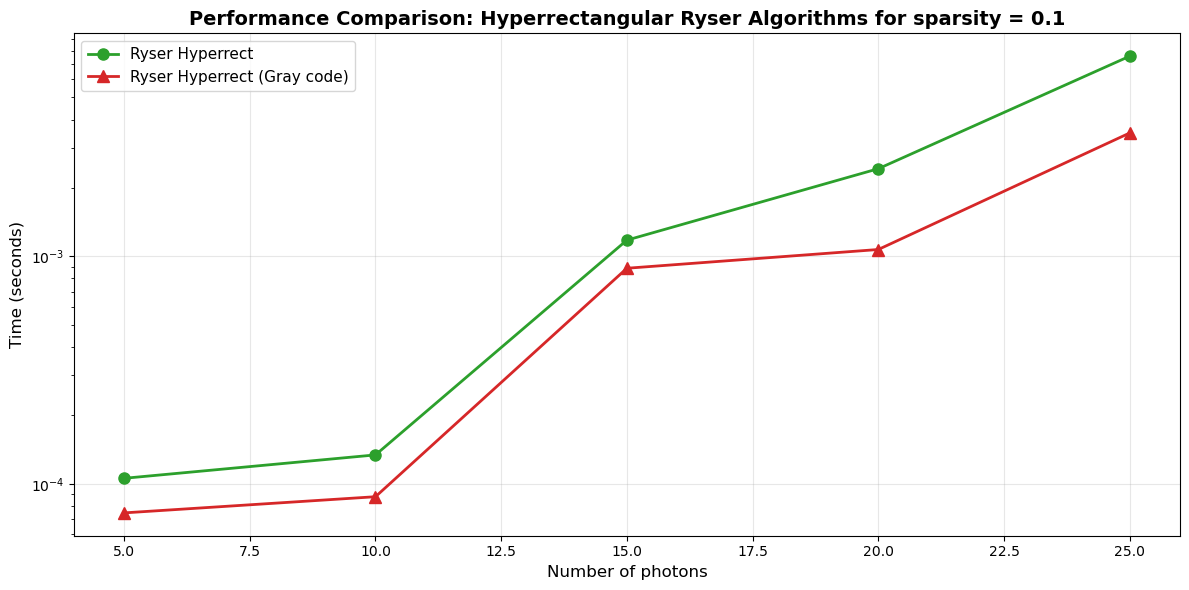


Speedup (Ryser vs Gray code):
  n=5: 1.42x faster
  n=10: 1.53x faster
  n=15: 1.33x faster
  n=20: 2.27x faster
  n=25: 2.18x faster


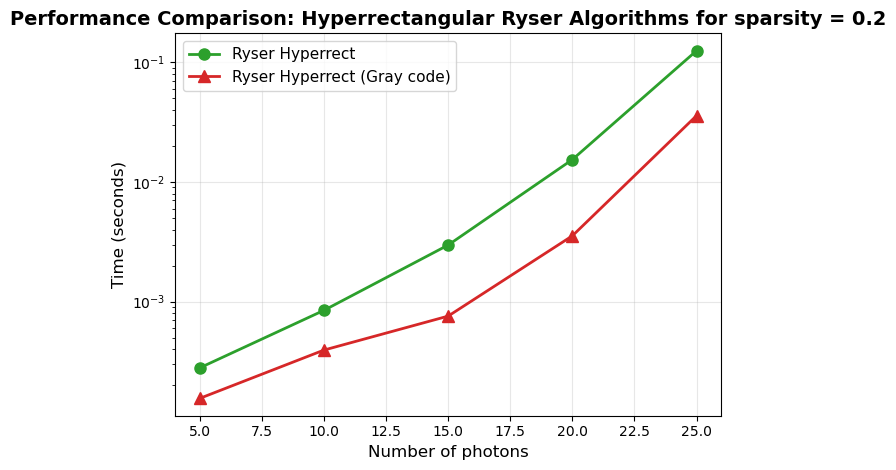


Speedup (Ryser vs Gray code):
  n=5: 1.80x faster
  n=10: 2.15x faster
  n=15: 3.92x faster
  n=20: 4.33x faster
  n=25: 3.49x faster


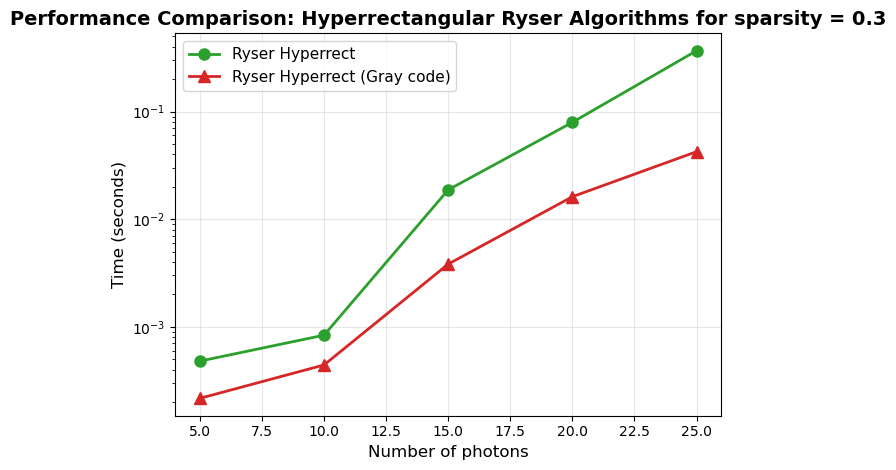


Speedup (Ryser vs Gray code):
  n=5: 2.22x faster
  n=10: 1.89x faster
  n=15: 4.90x faster
  n=20: 4.92x faster
  n=25: 8.69x faster


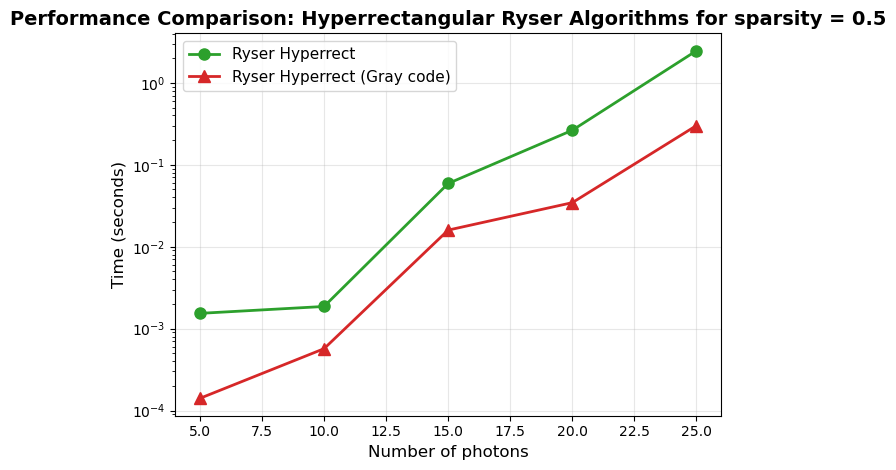


Speedup (Ryser vs Gray code):
  n=5: 10.89x faster
  n=10: 3.28x faster
  n=15: 3.71x faster
  n=20: 7.65x faster
  n=25: 8.20x faster


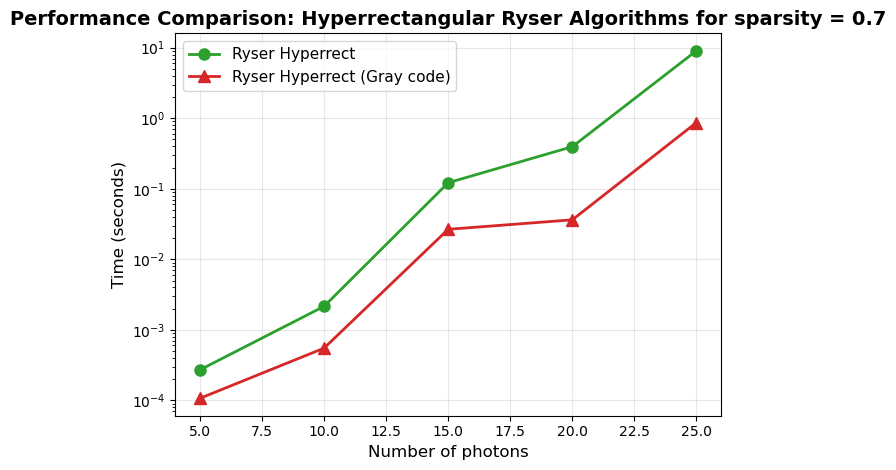


Speedup (Ryser vs Gray code):
  n=5: 2.53x faster
  n=10: 3.92x faster
  n=15: 4.57x faster
  n=20: 10.89x faster
  n=25: 10.43x faster


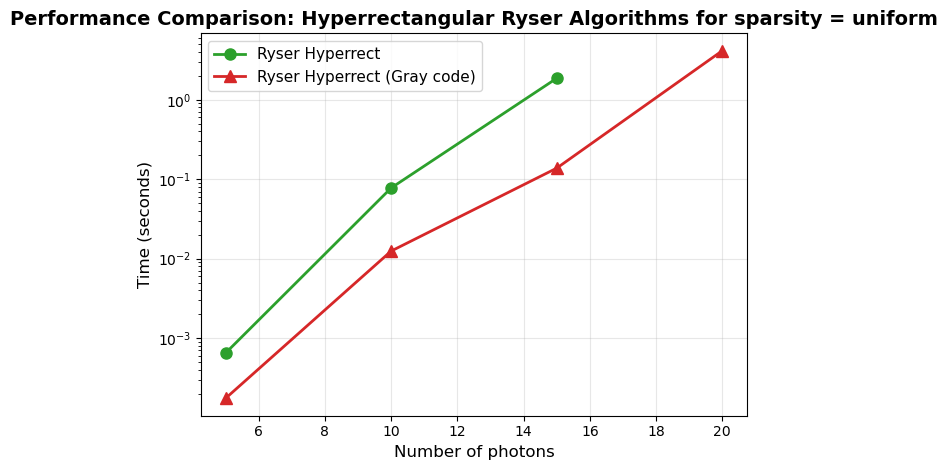


Speedup (Ryser vs Gray code):
  n=5: 3.71x faster
  n=10: 6.23x faster
  n=15: 13.54x faster
  n=20: N/A due to timeout
  n=25: N/A due to timeout


In [6]:
sizes = results_hyperrect['uniform']['photons']
# Plot comparison of hyperrectangular Ryser algorithms
plt.figure(figsize=(12, 6))
for sparsity in results_hyperrect.keys():
    res = results_hyperrect[sparsity]
    photons = res['photons']
    plt.plot(photons, res['ryser_hyperrect'], 'o-', label='Ryser Hyperrect', linewidth=2, markersize=8, color='#2ca02c')
    plt.plot(photons, res['ryser_hyperrect_gray'], '^-', label='Ryser Hyperrect (Gray code)', linewidth=2, markersize=8, color='#d62728')

    plt.xlabel('Number of photons', fontsize=12)
    plt.ylabel('Time (seconds)', fontsize=12)
    plt.title(f'Performance Comparison: Hyperrectangular Ryser Algorithms for sparsity = {sparsity}', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11, loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

    # Compute speedup
    speedup_hyperrect = [
        res['ryser_hyperrect'][i] / res['ryser_hyperrect_gray'][i]
        if (res['ryser_hyperrect'][i] is not None and res['ryser_hyperrect_gray'][i] is not None) 
        else None for i in range (len(sizes))]
    print(f"\nSpeedup (Ryser vs Gray code):")
    for n, s in zip(sizes, speedup_hyperrect):
        print(f"  n={n}: {s:.2f}x faster" if s is not None else f"  n={n}: N/A due to timeout")

## Section 3: Comprehensive Algorithm Comparison

Direct comparison of all four algorithms on the same test cases with photon repeated sub-matrices.

In [10]:
def benchmark_all_algorithms(max_photons=8, step=2, num_trials=5, photon_mode_ratio=10, sparsity='uniform', timeout_seconds=30):
    """Comprehensive benchmark of all four algorithms on the same matrices.
    
    Parameters
    ----------
    max_photons : int
        Maximum number of total photons to test.
    step : int
        Step size for increasing the number of photons.
    num_trials : int
        Number of trials for each configuration.
    photon_mode_ratio : int or string
        Ratio of the number of modes N compared to the number of photons n. If 'square', N = n^2.
    sparsity : float or str
        Sparsity level for photon distribution (number of non-zero occupations expressed as a
        fraction of the number of photons). If 'uniform', uses uniform distribution.
    timeout_seconds : int
        Maximum time (in seconds) to allow for each ryser_hyperrect() and ryser_hyperrect_gray() call.
    
    Returns
    -------
    dict
        Dictionary containing timing results for all algorithms.
    """
    results = {
        'ryser': [],
        'ryser_gray': [],
        'ryser_hyperrect': [],
        'ryser_hyperrect_gray': []
    }
    
    photon_counts = range(step, max_photons+1, step)
    
    for n_photons in photon_counts:
        times = {key: [] for key in results.keys()}
        N = photon_mode_ratio * n_photons if photon_mode_ratio != 'square' else n_photons**2
        
        print(f"Testing all algorithms {N} modes (base matrix {N}×{N}) and {n_photons} photons...")
        
        for trial in range(num_trials):
            U = random_unitary(N)
            
            # Random photon distribution
            if sparsity == 'uniform':
                vecn = random_fock_uniform(n_photons, N)
                vecm = random_fock_uniform(n_photons, N)
            else:
                vecn = random_fock_sparse(n_photons, N, ceil(n_photons * sparsity))
                vecm = random_fock_sparse(n_photons, N, ceil(n_photons * sparsity))
            
            # Standard Ryser on full repeated matrix
            repeated_U = repeat_matrix(U, vecn, vecm)
            
            # Benchmark ryser with timeout
            try:
                signal.signal(signal.SIGALRM, timeout_handler)
                signal.alarm(timeout_seconds)  # Active le timeout
                
                start = time.time()
                _ = ryser(repeated_U)
                t_ryser = time.time() - start
                times["ryser"].append(t_ryser)
                
                signal.alarm(0)
            except TimeoutException:
                print(f"  ⚠️  Ryser TIMEOUT (>{timeout_seconds}s) at n={n}, trial {trial+1}")
                times["ryser"].append(None)
            
            # Benchmark ryser_gray with timeout
            try:
                signal.signal(signal.SIGALRM, timeout_handler)
                signal.alarm(timeout_seconds)
                
                start = time.time()
                _ = ryser_gray(repeated_U)
                t_ryser_gray = time.time() - start
                times["ryser_gray"].append(t_ryser_gray)
                
                signal.alarm(0)
            except TimeoutException:
                print(f"  ⚠️  Ryser Gray TIMEOUT (>{timeout_seconds}s) at n={n}, trial {trial+1}")
                times["ryser_gray"].append(None)
            
            
            # Benchmark ryser_hyperrect
            try:
                signal.signal(signal.SIGALRM, timeout_handler)
                signal.alarm(timeout_seconds)
                
                start = time.time()
                _ = ryser_hyperrect(U, vecn, vecm, n=n_photons)
                times["ryser_hyperrect"].append(time.time() - start)
                
                signal.alarm(0)  # Désactive le timeout
            except TimeoutException:
                print(f"  ⚠️  Ryser hyperrect TIMEOUT (>{timeout_seconds}s) at n={n}, trial {trial+1}")
                times["ryser_hyperrect"].append(None)
            
            # Benchmark ryser_hyperrect_gray
            try:
                signal.signal(signal.SIGALRM, timeout_handler)
                signal.alarm(timeout_seconds)
                
                start = time.time()
                _ = ryser_hyperrect_gray(U, vecn, vecm, n=n_photons)
                times["ryser_hyperrect_gray"].append(time.time() - start)
                
                signal.alarm(0)  # Désactive le timeout
            except TimeoutException:
                print(f"  ⚠️  Ryser hyperrect Gray TIMEOUT (>{timeout_seconds}s) at n={n}, trial {trial+1}")
                times["ryser_hyperrect_gray"].append(None)
        
        for key in results.keys():
            valid_times = [t for t in times[key] if t is not None]
            if valid_times:
                results[key].append(np.mean(times[key]))
            else:
                results[key].append(None)
        
        print(f"  Ryser: {results['ryser'][-1] if results['ryser'][-1] else 'N/A':>8}, "
              f"Ryser Gray: {results['ryser_gray'][-1] if results['ryser_gray'][-1] else 'N/A':>8}, "
              f"Hyperrect: {results['ryser_hyperrect'][-1]:.4f}s, "
              f"Hyperrect Gray: {results['ryser_hyperrect_gray'][-1]:.4f}s")
    
    results['photons'] = list(photon_counts)
    return results

# Run comprehensive benchmark
print("\n" + "="*80)
print("COMPREHENSIVE ALGORITHM BENCHMARK")
print("="*80)
results_all = benchmark_all_algorithms(max_photons=25, step=5, num_trials=3, photon_mode_ratio=10, sparsity=0.5, timeout_seconds=30)
print("\nBenchmark completed!")


COMPREHENSIVE ALGORITHM BENCHMARK
Testing all algorithms 50 modes (base matrix 50×50) and 5 photons...
  Ryser: 9.131431579589844e-05, Ryser Gray: 0.00010156631469726562, Hyperrect: 0.0008s, Hyperrect Gray: 0.0002s
Testing all algorithms 100 modes (base matrix 100×100) and 10 photons...
  Ryser: 0.0050580501556396484, Ryser Gray: 0.001778999964396159, Hyperrect: 0.0013s, Hyperrect Gray: 0.0015s
Testing all algorithms 150 modes (base matrix 150×150) and 15 photons...
  Ryser: 0.27007850011189777, Ryser Gray: 0.05068333943684896, Hyperrect: 0.0129s, Hyperrect Gray: 0.0037s
Testing all algorithms 200 modes (base matrix 200×200) and 20 photons...
  Ryser: 6.11447795232137, Ryser Gray: 1.5550933678944905, Hyperrect: 0.0652s, Hyperrect Gray: 0.0111s
Testing all algorithms 250 modes (base matrix 250×250) and 25 photons...
  ⚠️  Ryser TIMEOUT (>30s) at n=25, trial 1
  ⚠️  Ryser Gray TIMEOUT (>30s) at n=25, trial 1
  ⚠️  Ryser TIMEOUT (>30s) at n=25, trial 2
  ⚠️  Ryser Gray TIMEOUT (>30s) at 

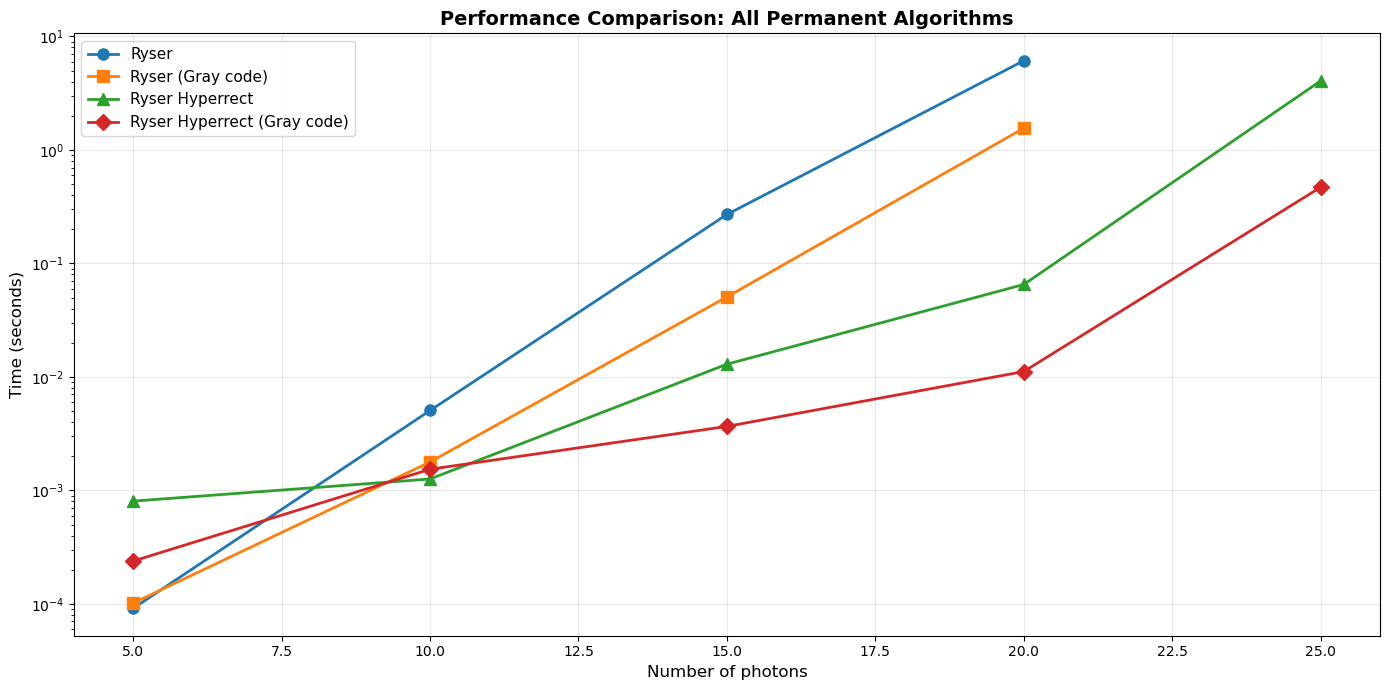

In [11]:
# Plot comparison of all algorithms
plt.figure(figsize=(14, 7))

photons = results_all['photons']

if any(t is not None for t in results_all['ryser']):
    valid_ryser = [(p, t) for p, t in zip(photons, results_all['ryser']) if t is not None]
    if valid_ryser:
        p_vals, t_vals = zip(*valid_ryser)
        plt.plot(p_vals, t_vals, 'o-', label='Ryser', linewidth=2, markersize=8, color='#1f77b4')

if any(t is not None for t in results_all['ryser_gray']):
    valid_ryser_gray = [(p, t) for p, t in zip(photons, results_all['ryser_gray']) if t is not None]
    if valid_ryser_gray:
        p_vals, t_vals = zip(*valid_ryser_gray)
        plt.plot(p_vals, t_vals, 's-', label='Ryser (Gray code)', linewidth=2, markersize=8, color='#ff7f0e')

plt.plot(photons, results_all['ryser_hyperrect'], '^-', label='Ryser Hyperrect', linewidth=2, markersize=8, color='#2ca02c')
plt.plot(photons, results_all['ryser_hyperrect_gray'], 'D-', label='Ryser Hyperrect (Gray code)', linewidth=2, markersize=8, color='#d62728')

plt.xlabel('Number of photons', fontsize=12)
plt.ylabel('Time (seconds)', fontsize=12)
plt.title('Performance Comparison: All Permanent Algorithms', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='upper left')
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()

## Section 4: Speedup Analysis

Analyzing the speedup factors of optimized algorithms compared to baseline implementations.

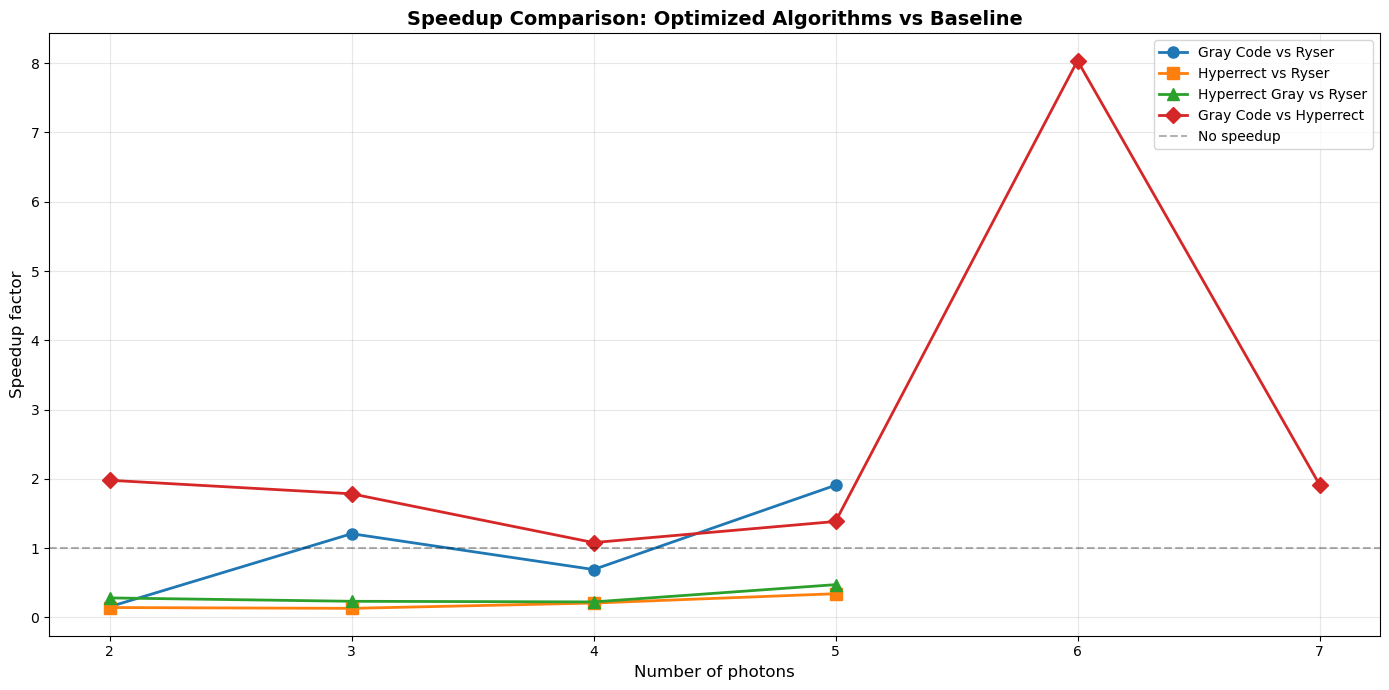


Speedup Summary:
--------------------------------------------------------------------------------
Photons    Gray vs Ryser   Hyperrect vs Ryser   Hyperrect Gray vs Hyperrect
--------------------------------------------------------------------------------
2          0.15x           0.14x                1.98x                    
3          1.21x           0.13x                1.78x                    
4          0.69x           0.21x                1.08x                    
5          1.91x           0.34x                1.38x                    
6          N/A             N/A                  8.04x                    
7          N/A             N/A                  1.92x                    


In [16]:
# Compute speedup factors
speedups = {
    'photons': results_all['photons'],
    'gray_vs_ryser': [],
    'hyperrect_vs_ryser': [],
    'hyperrect_gray_vs_ryser': [],
    'gray_vs_hyperrect': []
}

for i in range(len(results_all['photons'])):
    # Gray code speedup over standard Ryser
    if results_all['ryser'][i] is not None and results_all['ryser_gray'][i] is not None:
        speedups['gray_vs_ryser'].append(results_all['ryser'][i] / results_all['ryser_gray'][i])
    else:
        speedups['gray_vs_ryser'].append(None)
    
    # Hyperrect vs standard Ryser
    if results_all['ryser'][i] is not None:
        speedups['hyperrect_vs_ryser'].append(results_all['ryser'][i] / results_all['ryser_hyperrect'][i])
    else:
        speedups['hyperrect_vs_ryser'].append(None)
    
    # Hyperrect Gray vs standard Ryser
    if results_all['ryser'][i] is not None:
        speedups['hyperrect_gray_vs_ryser'].append(results_all['ryser'][i] / results_all['ryser_hyperrect_gray'][i])
    else:
        speedups['hyperrect_gray_vs_ryser'].append(None)
    
    # Gray code speedup for hyperrect
    speedups['gray_vs_hyperrect'].append(results_all['ryser_hyperrect'][i] / results_all['ryser_hyperrect_gray'][i])

# Plot speedup factors
plt.figure(figsize=(14, 7))

photons = speedups['photons']

if any(s is not None for s in speedups['gray_vs_ryser']):
    valid_gray_vs_ryser = [(p, s) for p, s in zip(photons, speedups['gray_vs_ryser']) if s is not None]
    if valid_gray_vs_ryser:
        p_vals, s_vals = zip(*valid_gray_vs_ryser)
        plt.plot(p_vals, s_vals, 'o-', label='Gray Code vs Ryser', linewidth=2, markersize=8, color='#1f77b4')

if any(s is not None for s in speedups['hyperrect_vs_ryser']):
    valid_hyperrect_vs_ryser = [(p, s) for p, s in zip(photons, speedups['hyperrect_vs_ryser']) if s is not None]
    if valid_hyperrect_vs_ryser:
        p_vals, s_vals = zip(*valid_hyperrect_vs_ryser)
        plt.plot(p_vals, s_vals, 's-', label='Hyperrect vs Ryser', linewidth=2, markersize=8, color='#ff7f0e')

if any(s is not None for s in speedups['hyperrect_gray_vs_ryser']):
    valid_hyperrect_gray_vs_ryser = [(p, s) for p, s in zip(photons, speedups['hyperrect_gray_vs_ryser']) if s is not None]
    if valid_hyperrect_gray_vs_ryser:
        p_vals, s_vals = zip(*valid_hyperrect_gray_vs_ryser)
        plt.plot(p_vals, s_vals, '^-', label='Hyperrect Gray vs Ryser', linewidth=2, markersize=8, color='#2ca02c')

plt.plot(photons, speedups['gray_vs_hyperrect'], 'D-', label='Gray Code vs Hyperrect', linewidth=2, markersize=8, color='#d62728')

plt.xlabel('Number of photons', fontsize=12)
plt.ylabel('Speedup factor', fontsize=12)
plt.title('Speedup Comparison: Optimized Algorithms vs Baseline', fontsize=14, fontweight='bold')
plt.axhline(y=1, color='k', linestyle='--', alpha=0.3, label='No speedup')
plt.legend(fontsize=10, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print speedup table
print("\nSpeedup Summary:")
print("-" * 80)
print(f"{'Photons':<10} {'Gray vs Ryser':<15} {'Hyperrect vs Ryser':<20} {'Hyperrect Gray vs Hyperrect':<25}")
print("-" * 80)
for i, p in enumerate(photons):
    gray_ryser = f"{speedups['gray_vs_ryser'][i]:.2f}x" if speedups['gray_vs_ryser'][i] is not None else "N/A"
    hyperrect_ryser = f"{speedups['hyperrect_vs_ryser'][i]:.2f}x" if speedups['hyperrect_vs_ryser'][i] is not None else "N/A"
    gray_hyperrect = f"{speedups['gray_vs_hyperrect'][i]:.2f}x"
    print(f"{p:<10} {gray_ryser:<15} {hyperrect_ryser:<20} {gray_hyperrect:<25}")

## Summary and Conclusions

### Key Findings:

1. **Gray Code Optimization**: The Gray code variant provides consistent speedup for standard Ryser algorithm
2. **Hyperrectangular Specialization**: Exploiting structure in repeated matrices provides dramatic speedup
3. **Combined Optimizations**: Hyperrect + Gray code delivers best performance for large photon counts
4. **Scalability**: Different algorithms scale differently - choose based on problem characteristics

### Recommendations:

- Use **Ryser** for small matrices or when structure is unknown
- Use **Ryser Gray** when working with standard complete unitary matrices
- Use **Ryser Hyperrect** when dealing with repeated sub-matrices
- Use **Ryser Hyperrect Gray** for production code with repeated sub-matrices

In [ ]:
# Final summary statistics
print("\n" + "="*80)
print("FINAL BENCHMARK SUMMARY")
print("="*80)

print("\nStandard Ryser Benchmarks:")
print(f"  Max size tested: {max(results_standard['sizes'])}×{max(results_standard['sizes'])}")
print(f"  Average speedup (Gray vs Ryser): {np.mean(speedup_standard):.2f}x")
print(f"  Best speedup: {np.max(speedup_standard):.2f}x")

print("\nHyperRectangular Benchmarks:")
print(f"  Max photons tested: {max(results_hyperrect['photons'])}")
print(f"  Average speedup (Gray vs Hyperrect): {np.mean(speedup_hyperrect):.2f}x")
print(f"  Best speedup: {np.max(speedup_hyperrect):.2f}x")

print("\nComprehensive Benchmarks:")
hyperrect_gray_speedups = [speedups['gray_vs_hyperrect'][i] for i in range(len(photons)) 
                           if speedups['gray_vs_hyperrect'][i] is not None]
if hyperrect_gray_speedups:
    print(f"  Average Hyperrect Gray speedup: {np.mean(hyperrect_gray_speedups):.2f}x")

print("\n" + "="*80)